In [1]:
!wget https://raw.githubusercontent.com/broccubali/NoisyICML/main/metrics/metrics_after_kan/results-burger.json
!wget https://raw.githubusercontent.com/broccubali/NoisyICML/main/metrics/metrics_after_kan/results-wave.json
!wget https://raw.githubusercontent.com/broccubali/NoisyICML/main/metrics/metrics_after_kan/results-heat.json

--2025-02-10 15:00:29--  https://raw.githubusercontent.com/broccubali/NoisyICML/main/metrics/metrics_after_kan/results-burger.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11325 (11K) [text/plain]
Saving to: ‘results-burger.json’

results-burger.json 100%[===================>]  11.06K  --.-KB/s    in 0s      

2025-02-10 15:00:30 (88.9 MB/s) - ‘results-burger.json’ saved [11325/11325]

--2025-02-10 15:00:30--  https://raw.githubusercontent.com/broccubali/NoisyICML/main/metrics/metrics_after_kan/results-wave.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent,

In [8]:
import pandas as pd

# Load DataFrame
df = pd.read_json("/kaggle/working/results-wave.json").T

# Convert dictionary columns into separate DataFrame columns
df_clean = df['clean'].apply(pd.Series).add_prefix("clean_")
df_noisy = df['noisy'].apply(pd.Series).add_prefix("noisy_")
df_pred = df['pred'].apply(pd.Series).add_prefix("pred_")

# Concatenate the extracted data with the original index
df_expanded = pd.concat([df_clean, df_noisy, df_pred], axis=1)

# Display the transformed DataFrame
df_expanded.mean()

clean_mse     0.012826
clean_loss    0.012832
noisy_mse     0.040183
noisy_loss    0.039806
pred_mse      0.012796
pred_loss     0.012738
dtype: float64

In [1]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(
            self.base_weight, a=math.sqrt(5) * self.scale_base
        )
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(
                    self.spline_scaler, a=math.sqrt(5) * self.scale_spline
                )

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [2]:
import torch
import torch.nn as nn
import numpy as np


class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lambda2):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList(
            [
                (
                    nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                    if i % 2 == 0
                    else nn.Tanh()
                )
                for i in range(20)
            ]
        )
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.lambda2 = lambda2

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def loss_fn(self, x, u):
        u_pred = self.forward(x)
        return self.loss(u_pred, u)

    def residual_loss(self, xtrain, fhat):
        x = xtrain[:, 0]
        t = xtrain[:, 1]
        g = xtrain.clone()
        g.requires_grad = True
        u_pred = self.forward(g)
        u_x_t = torch.autograd.grad(
            u_pred,
            g,
            torch.ones([xtrain.shape[0], 1]).to("cuda"),
            retain_graph=True,
            create_graph=True,
        )[0]
        u_xx_tt = torch.autograd.grad(
            u_x_t, g, torch.ones(xtrain.shape).to("cuda"), create_graph=True
        )[0]
        u_x = u_x_t[:, [0]]
        u_t = u_x_t[:, [1]]
        u_xx = u_xx_tt[:, [0]]
        return self.loss(u_t + (u_pred * u_x) - (self.lambda2 * u_xx), fhat)

    def total_loss(self, xtrain, utrain, fhat):
        return self.loss_fn(xtrain, utrain) + self.residual_loss(xtrain, fhat)

    def train_model(self, xtrain, utrain, epochs=1000):
        fhat = torch.zeros(xtrain.shape[0], 1, device="cuda")
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.total_loss(xtrain, utrain, fhat)
            loss.backward()
            self.optimizer.step()
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, Loss {loss.item()}")
        return loss.item()

In [3]:
from math import ceil

dt_save = 0.01
ini_time = 0.0
fin_time = 2.0
nx = 1024
xL = -1.0
xR = 1.0
dx = (xR - xL) / nx
xe = np.linspace(xL, xR, nx + 1)
x = xe[:-1] + 0.5 * dx
it_tot = ceil((fin_time - ini_time) / dt_save) + 1
t = np.arange(it_tot + 1) * dt_save
X, T = np.meshgrid(x, t[:-1])
xtrue = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
xtrue = torch.tensor(xtrue, dtype=torch.float32, device="cuda")

In [9]:
def loadAndPrep(u):
    idx = np.random.choice(u.flatten().shape[0], 10000, replace=False)
    xtrain = xtrue[idx, :]
    utrain = u.flatten()[idx][:, None]
    utrain = torch.tensor(utrain, dtype=torch.float32).to("cuda")
    return xtrain, utrain


def trainAndLog(u, pinn):
    xtrain, utrain = loadAndPrep(u)
    loss = pinn.train_model(xtrain, utrain, epochs=5000)
    with torch.no_grad():
        pred = pinn(xtrue).cpu().numpy()


def clean(u):
    with torch.no_grad():
        u = torch.tensor(u.T, dtype=torch.float32).to(device)
        u = kan(u)
        u = u.cpu().numpy().T
    return u

In [18]:
import h5py
with h5py.File("/kaggle/input/burgers-clean/simulation_data.h5", "r") as f:
    a = f["0"]["clean"][:]
    b = f["0"]["noisy"][:]
    e = f["0"]["epsilon"][()]
a.shape, b.shape, e

((201, 1024), (201, 1024), 0.07904966802904742)

In [19]:
model = KAN([201, 512, 512, 1024, 512, 512, 201]).to("cuda")
model.load_state_dict(torch.load("/kaggle/input/kan/pytorch/thisshitworks/1/model.pth", weights_only=True))

<All keys matched successfully>

In [20]:
c = model(torch.tensor(a).T.to("cuda")).detach().cpu().numpy().T
c.shape

(201, 1024)

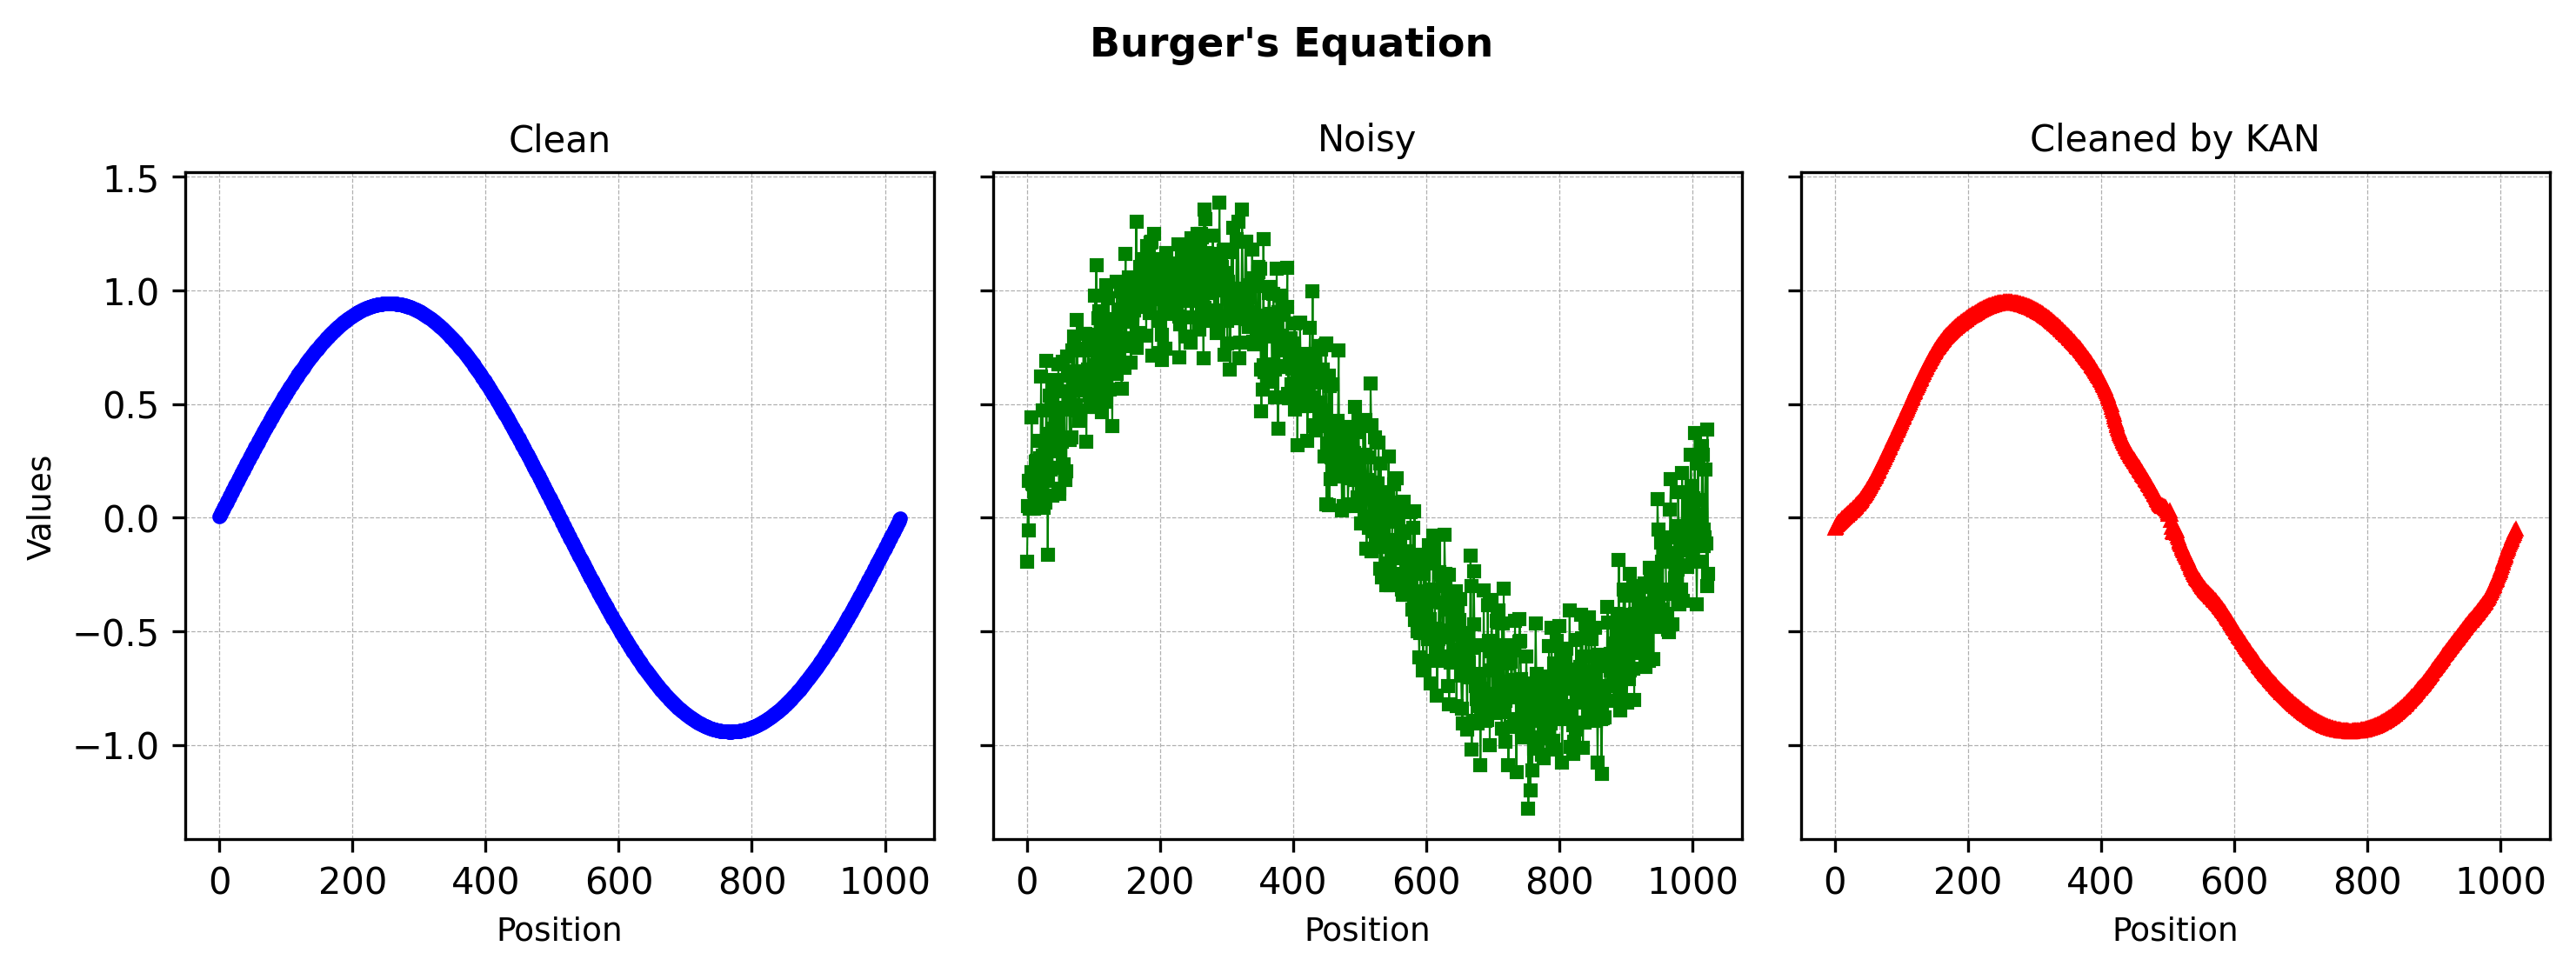

In [21]:
import matplotlib.pyplot as plt

# Create subplots (1 row, 3 columns) with IEEE-style formatting
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=300)

# Plot each array in its respective subplot with very thin lines
axes[0].plot(a[0, :], marker='o', color='b', linewidth=0.5, markersize=3)
axes[0].set_title("Clean", fontsize=10)
axes[0].set_xlabel("Position", fontsize=9)
axes[0].set_ylabel("Values", fontsize=9)
axes[0].grid(True, linestyle="--", linewidth=0.3)

axes[1].plot(b[0, :], marker='s', color='g', linewidth=0.5, markersize=3)
axes[1].set_title("Noisy", fontsize=10)
axes[1].set_xlabel("Position", fontsize=9)
axes[1].grid(True, linestyle="--", linewidth=0.3)

axes[2].plot(c[0, :], marker='^', color='r', linewidth=0.5, markersize=3)
axes[2].set_title("Cleaned by KAN", fontsize=10)
axes[2].set_xlabel("Position", fontsize=9)
axes[2].grid(True, linestyle="--", linewidth=0.3)

# Overall title (optional)
fig.suptitle("Burger's Equation", fontsize=11, fontweight='bold')


# Adjust layout for IEEE formatting
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Extra space for caption

# Save the figure in high resolution for IEEE papers
plt.savefig("ieee_figure.png", dpi=300, bbox_inches='tight')

# Show the plots
plt.show()


In [10]:
s = []
for i in [a, b, c]:
    pinn = PINN(input_size=2, hidden_size=20, output_size=1, lambda2=e).to("cuda")
    u = torch.tensor(i).to("cuda")
    trainAndLog(u, pinn)
    with torch.no_grad():
        s.append(pinn(xtrue).detach().cpu().numpy())

<ipython-input-9-b5145c9532be>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  utrain = torch.tensor(utrain, dtype=torch.float32).to("cuda")
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss 0.27180179953575134
Epoch 1000, Loss 0.01482338272035122
Epoch 2000, Loss 0.014023063704371452
Epoch 3000, Loss 0.013608730398118496
Epoch 4000, Loss 0.013419624418020248
Epoch 0, Loss 0.2199091762304306
Epoch 1000, Loss 0.04830551892518997
Epoch 2000, Loss 0.04614454135298729
Epoch 3000, Loss 0.04482141137123108
Epoch 4000, Loss 0.04412407800555229
Epoch 0, Loss 0.20269373059272766
Epoch 1000, Loss 0.015546395443379879
Epoch 2000, Loss 0.014603547751903534
Epoch 3000, Loss 0.01430200319737196
Epoch 4000, Loss 0.01506534218788147


In [23]:
a, b, c = s

In [24]:
a = a.reshape((201, 1024))
b = b.reshape((201, 1024))
c = c.reshape((201, 1024))

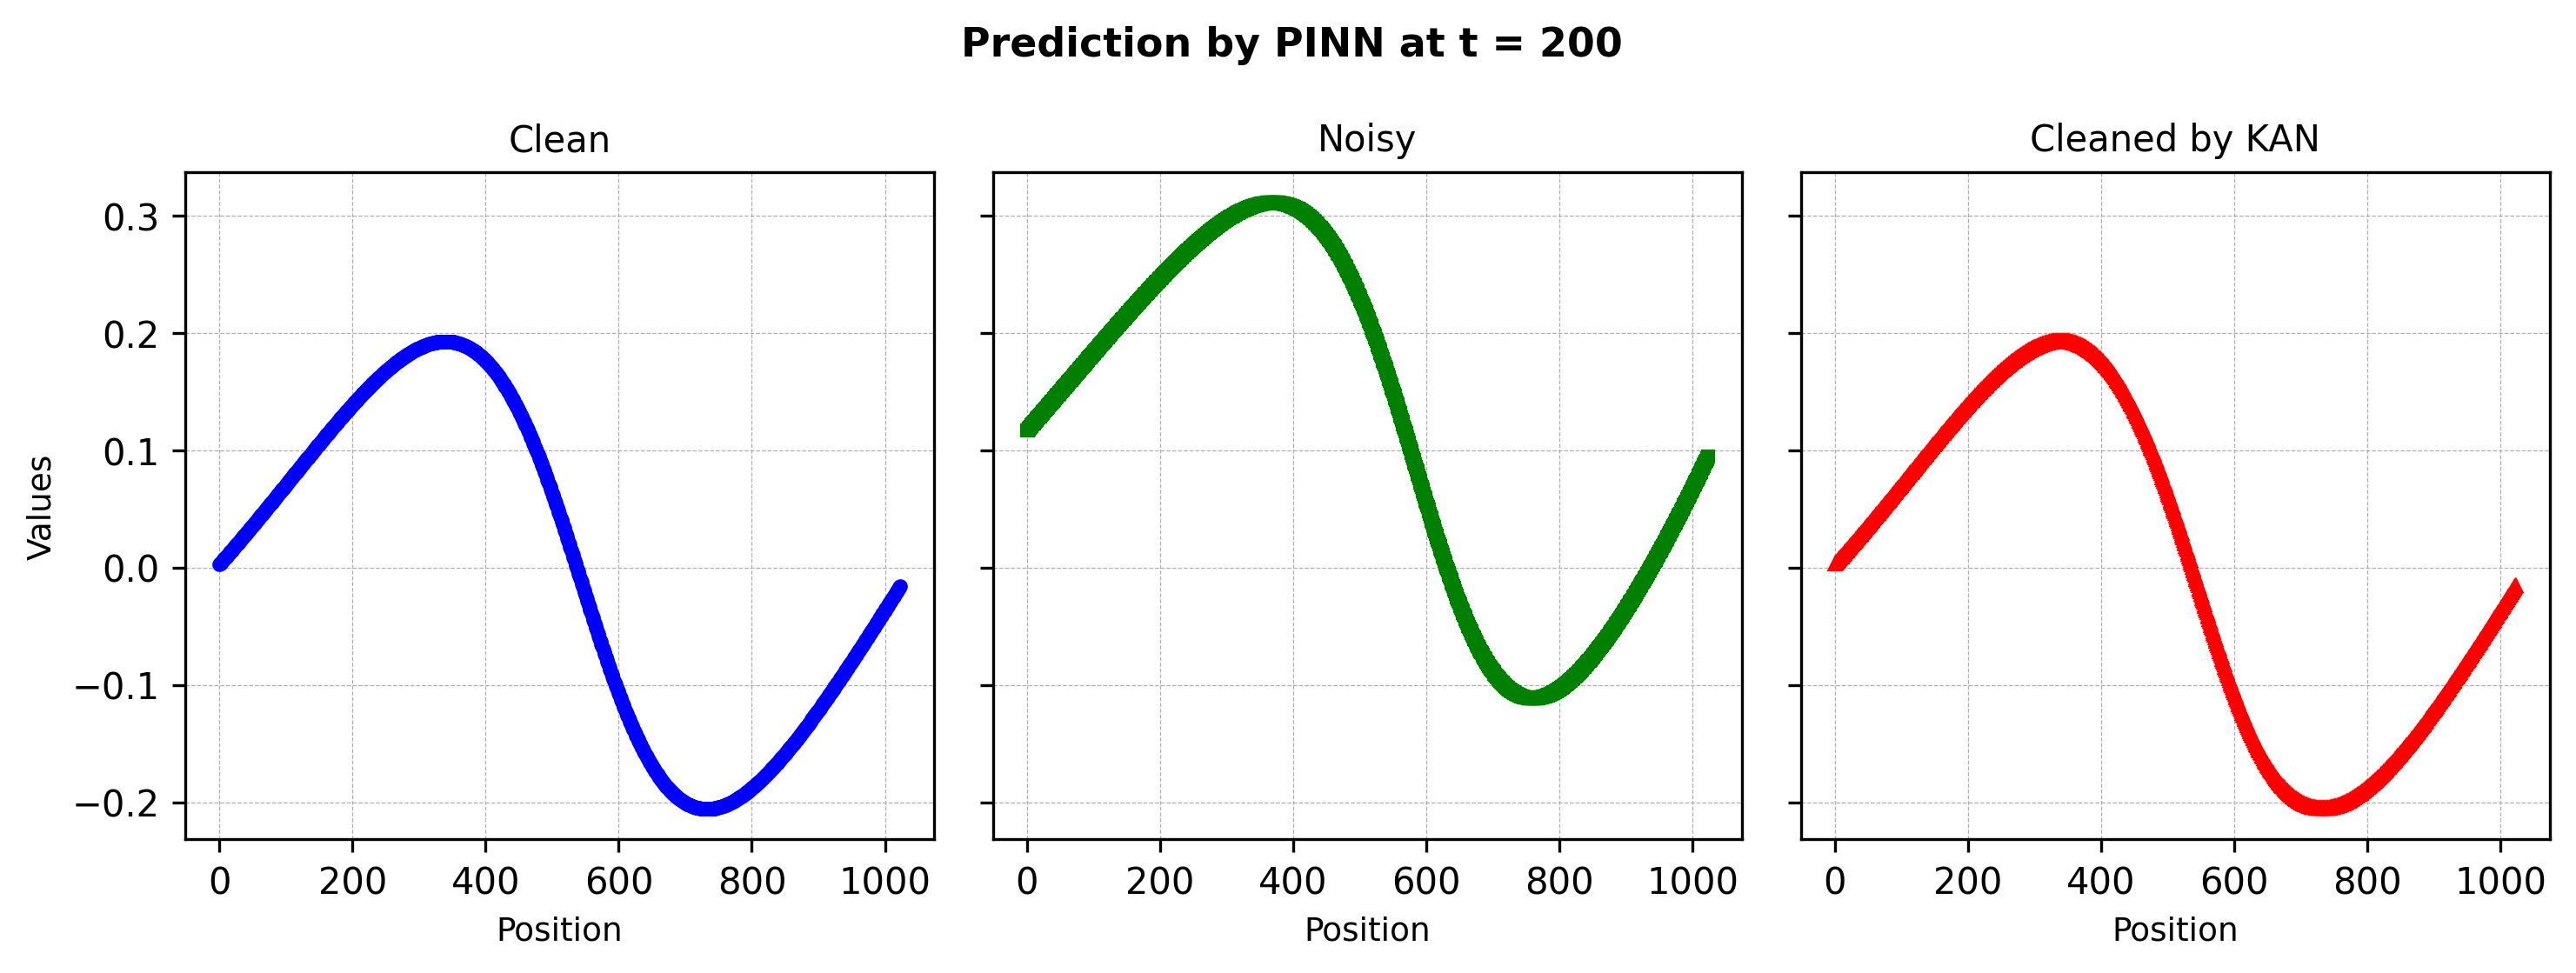

In [32]:
import matplotlib.pyplot as plt

# Create subplots (1 row, 3 columns) with IEEE-style formatting
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=300)

# Plot each array in its respective subplot with very thin lines
axes[0].plot(a[200, :], marker='o', color='b', linewidth=0.5, markersize=3)
axes[0].set_title("Clean", fontsize=10)
axes[0].set_xlabel("Position", fontsize=9)
axes[0].set_ylabel("Values", fontsize=9)
axes[0].grid(True, linestyle="--", linewidth=0.3)

axes[1].plot(b[200, :], marker='s', color='g', linewidth=0.5, markersize=3)
axes[1].set_title("Noisy", fontsize=10)
axes[1].set_xlabel("Position", fontsize=9)
axes[1].grid(True, linestyle="--", linewidth=0.3)

axes[2].plot(c[200, :], marker='^', color='r', linewidth=0.5, markersize=3)
axes[2].set_title("Cleaned by KAN", fontsize=10)
axes[2].set_xlabel("Position", fontsize=9)
axes[2].grid(True, linestyle="--", linewidth=0.3)

# Overall title (optional)
fig.suptitle("Prediction by PINN at t = 200", fontsize=11, fontweight='bold')


# Adjust layout for IEEE formatting
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Extra space for caption

# Save the figure in high resolution for IEEE papers
plt.savefig("ieee_figure.png", dpi=300, bbox_inches='tight')

# Show the plots
plt.show()